# Fukuchi (2018) - Analysis

This notebook demonstrates how the data from [Fukuchi et al. (2018)](https://peerj.com/articles/4640/) were analyzed. Data importing and processing are detailed in a separate notebook. This notebook analyzes preprocessed data.

**References**:

Fukuchi, C. A., Fukuchi, R. K., & Duarte, M. (2018). A public dataset of overground and treadmill walking kinematics and kinetics in healthy individuals. PeerJ, 6, e4640.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import spm1d
import detrend1d as dtr

<br>
<br>

### Load data:

In [2]:
dirDATA   = os.path.join(   os.path.split( os.getcwd() )[0],   'Data'   )
fpath     = os.path.join(dirDATA, 'Fukuchi2018', 'processed.npz')
with np.load(fpath) as z:
	y,c   = z['y'], z['c']

hz        = 300
i0,i1     = 0, 1   # indices of trials to compare
comp      = 0      # GRF component to analyze
y0,y1     = y[i0,:,comp],y[i1,:,comp]  # GRF
c0,c1     = c[i0],c[i1]   # cycle labels
t0,t1     = np.arange(y0.shape[0])/hz, np.arange(y1.shape[0])/hz  # time vectors

<br>
<br>

### Fit trends:

In [3]:
_,fit0    = dtr.detrend(t0, y0)
_,fit1    = dtr.detrend(t1, y1)
_,fitI0   = dtr.detrend_intracycle(t0, y0, c0, trend='linear')
_,fitI1   = dtr.detrend_intracycle(t1, y1, c1, trend='linear')

<br>
<br>

### Get registered (time-normalized) data:

In [4]:

y0i,y1i   = fit0.get_detrended_registered( c0 ), fit1.get_detrended_registered( c1 )
y0r,y1r   = [fit.get_registered()  for fit in (fitI0,fitI1)]
y0I,y1I   = [fit.get_detrended_registered( mean_centered=True )  for fit in (fitI0,fitI1)]


# retain first n steps for analysis:
n = 10
y0r,y1r   = y0r[:n],y1r[:n]
y0i,y1i   = y0i[:n],y1i[:n]
y0I,y1I   = y0I[:n],y1I[:n]

<br>
<br>

### SPM analysis:

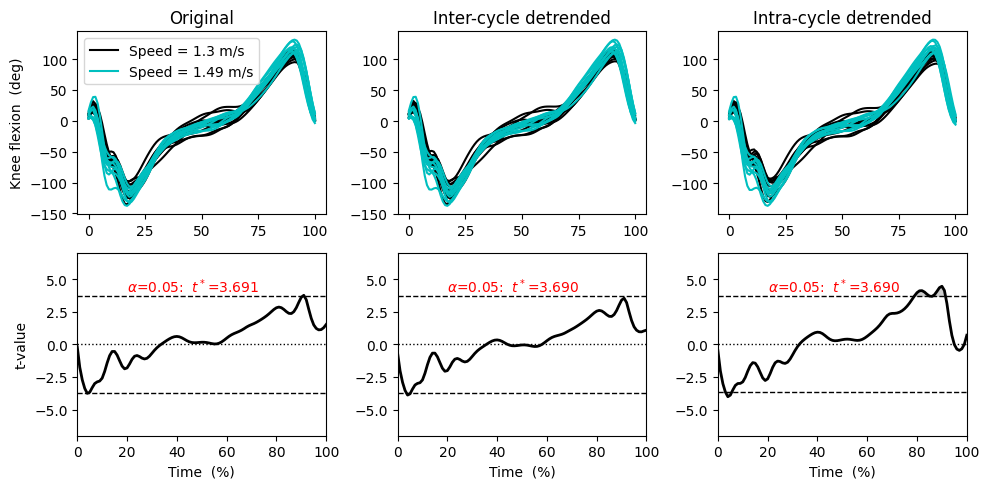

In [5]:
spm0      = spm1d.stats.ttest2(y1r, y0r).inference(0.05)
spm1      = spm1d.stats.ttest2(y1i, y0i).inference(0.05)
spm2      = spm1d.stats.ttest2(y1I, y0I).inference(0.05)


# plot results:
fig,axs = plt.subplots( 2, 3, figsize=(10,5), tight_layout=True )
ax0,ax1,ax2,ax3,ax4,ax5 = axs.flatten()
speeds_ms = [1.3, 1.49, 1.69, 1.88]
# plot GRF data:
h0 = ax0.plot(y0r.T, 'k')[0];  h1=ax0.plot(y1r.T, 'c')[1]
ax1.plot(y0i.T, 'k');  ax1.plot(y1i.T, 'c')
ax2.plot(y0I.T, 'k');  ax2.plot(y1I.T, 'c')
ax0.legend([h0,h1],[f'Speed = {speeds_ms[i]} m/s'  for i in (i0,i1)])
# plot SPM results:
spm0.plot( ax=ax3 );  spm0.plot_threshold_label( ax=ax3, pos=(20,4) )
spm1.plot( ax=ax4 );  spm1.plot_threshold_label( ax=ax4, pos=(20,4) )
spm2.plot( ax=ax5 );  spm2.plot_threshold_label( ax=ax5, pos=(20,4) )
[ax.set_xlabel('Time  (%)')   for ax in axs[1]]
ax0.set_ylabel('Knee flexion  (deg)', size=10)
ax3.set_ylabel('t-value', size=10)
[ax.set_ylabel(None)  for ax in [ax1,ax2,ax4,ax5]]
[ax.set_ylim(-7,7)  for ax in axs[1]]
labels = 'Original', 'Inter-cycle detrended', 'Intra-cycle detrended'
[ax.set_title(s) for ax,s in zip(axs[0],labels)]
plt.show()